```
This notebook analyses the area around the North Cape
Copyright (C) 2022 - 2023 SINTEF Digital
Copyright (C) 2022 - 2023 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 26b98e82e8d4e1ca2369cf735af8c7d3af460403 on branch reduced_gravity


# Barents Sea

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

import datetime

#For plotting
import matplotlib
from matplotlib import pyplot as plt

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [4]:
%cuda_context_handler barotropic_gpu_ctx

Path to the test file

In [5]:
source_url = "/lustre/storeB/project/fou/hi/NorFjords160/A12/norfjords_160m_his.nc4_2020020101-2020020200"
source_url = "/sintef/data/NorFjords160/A12/norfjords_160m_his.nc4_2020020101-2020020200"

## Inspecting file structure and content

In [6]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 24, s_rho: 35, s_w: 36, eta_rho: 1271, xi_rho: 2051, eta_u: 1271, xi_u: 2050, eta_v: 1270, xi_v: 2051)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2020-02-01T01:00:00 ... 2020-02-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  # Remove the CWD from sys.path while we load stuff.


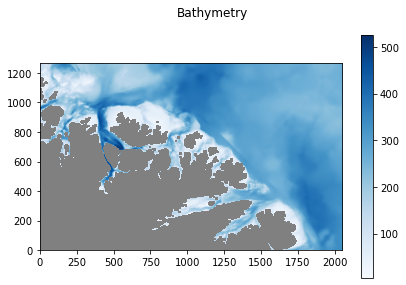

In [7]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][1:-1,1:-1], mask=(1-nc["mask_rho"][1:-1,1:-1]))

fig, ax = plt.subplots()
fig.suptitle("Bathymetry")

cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)
im = ax.imshow(H_m, cmap=cmap, origin="lower")

plt.colorbar(im, ax=ax)
plt.tight_layout()

## Generating GPUOcean Simulation from Input

In [8]:
dimY, dimX = ds.h.data.shape

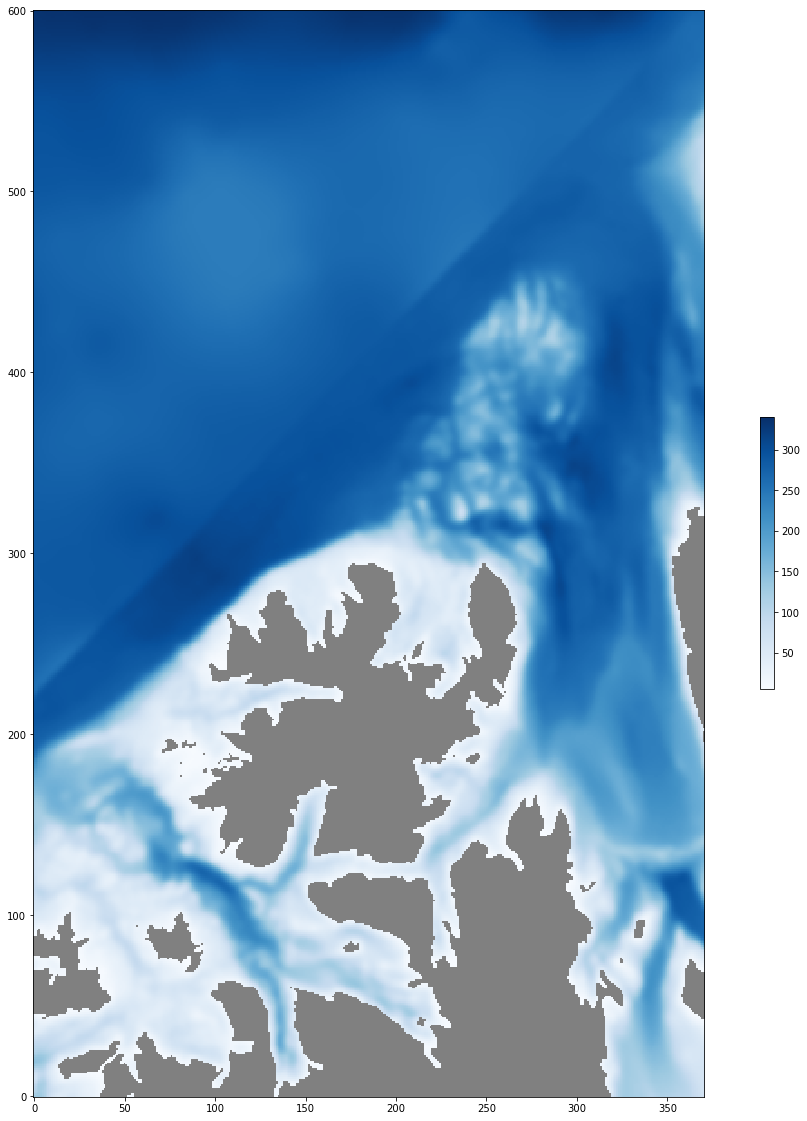

In [9]:
x0, x1, y0, y1 = 1100, dimX-350, 315, dimY-585

fig, ax = plt.subplots(figsize=(20,20))
im= ax.imshow(np.flip(np.ma.array(nc["h"][y0:y1, x0:x1], mask = 1-nc["mask_rho"][y0:y1,x0:x1]), axis=0).T, interpolation="none", cmap="Blues", origin="lower")
plt.colorbar(im, shrink=0.25)

In [10]:
nc.variables.keys()

dict_keys(['ocean_time', 'Vtransform', 'Vstretching', 'theta_s', 'theta_b', 'Tcline', 'hc', 's_rho', 's_w', 'Cs_r', 'Cs_w', 'h', 'mask_rho', 'mask_u', 'mask_v', 'angle', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'aice', 'hice', 'snow_thick', 'uice', 'vice', 'zeta', 'ubar', 'vbar', 'Uwind', 'Vwind', 'swrad', 'u', 'v', 'temp', 'salt', 'AKt', 'AKs'])

In [11]:
nx = (x1-x0)
ny = (y1-y0)

NX = nx+4
NY = ny+4

dx = 160.0
dy = 160.0

Check Mixed-Layer Depth

In [12]:
t=12

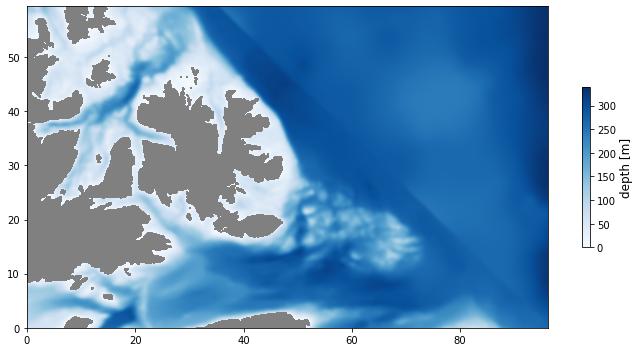

In [13]:
cmap = copy.copy(plt.cm.Blues)
cmap.set_bad("grey", alpha = 1.0)

domain_extent = [0, (x1-x0)*160/1000, 0, (y1-y0)*160/1000]

with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    im = ax.imshow(np.ma.array(nc["h"][y0:y1,x0:x1], mask=(1-nc["mask_rho"][y0:y1,x0:x1])), 
                   vmin=0, origin="lower",
                   cmap=cmap, extent=domain_extent)
    
    cb = plt.colorbar(im, ax=ax, shrink=0.5)
    cb.set_label(label="depth [m]", size=12)
    plt.tight_layout()



In [12]:
t = 9
print(str(datetime.datetime.utcfromtimestamp(nc["ocean_time"][t]).strftime('%Y-%m-%d %H:%M:%S')))

2042-02-01 10:00:00


Check densities

In [15]:
y_cut = 450

2042-02-01 10:00:00


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))


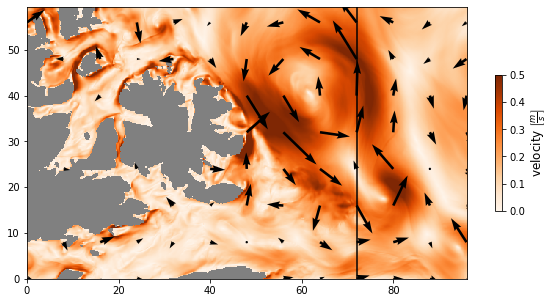

In [16]:

H_m = nc["h"][y0:y1,x0:x1]

bt_u = 0.5*(nc["ubar"][t,y0:y1,x0:x1]+nc["ubar"][t,y0:y1,x0+1:x1+1])
bt_v = 0.5*(nc["vbar"][t,y0:y1,x0:x1]+nc["vbar"][t,y0+1:y1+1,x0:x1])

bt_velocity = np.sqrt(bt_u*bt_u + bt_v*bt_v)

ny, nx = bt_velocity.shape
dx, dy = 0.160, 0.160
domain_extent = [0, nx*dx, 0, ny*dy]

frequency_x = 50
frequency_y = 50
x = np.arange(0, bt_velocity.shape[1], frequency_x)*dx
y = np.arange(0, bt_velocity.shape[0], frequency_y)*dy
bt_qu = bt_u[::frequency_y, ::frequency_x]
bt_qv = bt_v[::frequency_y, ::frequency_x]


# ----------------------------

with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(figsize=(10,5))

    # ax.tick_params(colors='black')
    ax.xaxis.label.set_color('black')

    velo_cmap = plt.cm.Oranges
    velo_cmap.set_bad("grey", alpha = 1.0)

    im = ax.imshow(bt_velocity, interpolation="none", origin='lower', 
                        cmap=velo_cmap,
                        vmin=0, vmax=0.5,
                        extent=domain_extent)
    ax.quiver(x,y,bt_qu,bt_qv, scale=5)

    cb = plt.colorbar(im, ax=ax, shrink=0.5)
    cb.set_label(label="velocity $\left[ \\frac{m}{s} \\right]$", size=12)
    
    ax.axvline(x=y_cut*dx, c="black")


print(str(datetime.datetime.utcfromtimestamp(nc["ocean_time"][t]).strftime('%Y-%m-%d %H:%M:%S')))


In [17]:
s_pot_densities = NetCDFInitialization.potentialDensities(source_url, t=t, x0=x0, x1=x1, y0=y0, y1=y1)

s_nc = Dataset(source_url)
s_hs   = s_nc["h"][y0:y1,x0:x1]
s_rhos = s_nc["Cs_r"][:]

depth_show_meters = 300 # upper layer thickness for plotting in meters

depth_show_resolution = 1 # discretisation levels per meter

s_pot_densities_show = np.ma.array(np.zeros((s_pot_densities.shape[1],depth_show_meters*depth_show_resolution)))
s_pot_densities_show[:,0] =  s_pot_densities[-1][:,y_cut]
for depth_level in range(1,depth_show_resolution*depth_show_meters):
    depth = depth_level/depth_show_resolution

    integrator_low = NetCDFInitialization.MLD_integrator(source_url, np.ma.array(depth*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
    dens_low = np.sum(integrator_low * s_pot_densities, axis=0)
    if depth_level == 1:
        dens_up = 0.0
        s_pot_densities_show[:,depth_level] =  (dens_low - dens_up)[:,y_cut]*depth_show_resolution
        mask_next_level = copy.copy(s_pot_densities_show[:,depth_level]<1000)
    else:
        integrator_up = NetCDFInitialization.MLD_integrator(source_url, np.ma.array((depth-1/depth_show_resolution)*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
        dens_up  = np.sum(integrator_up * s_pot_densities, axis=0)
        s_pot_densities_show[:,depth_level] =  (dens_low - dens_up)[:,y_cut]*depth_show_resolution
        s_pot_densities_show[:,depth_level].mask = copy.copy(mask_next_level)
        if depth > 5:
            mask_next_level = np.all((integrator_low[1:,:,y_cut] == integrator_up[1:,:,y_cut]), axis=0)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd_r"))
  after removing the cwd from sys.path.


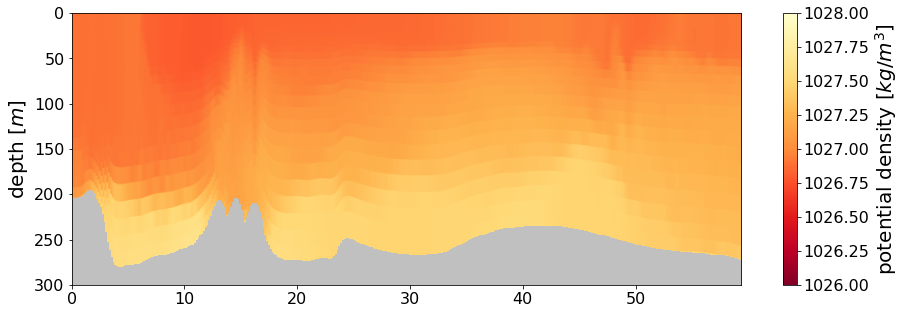

In [18]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

cmap_dens = plt.cm.YlOrRd_r
cmap_dens.set_bad(alpha=0.25)

extent = [0, s_pot_densities_show.shape[0]*160/1000, depth_show_meters, 0]

im = ax.imshow(s_pot_densities_show.T, 
                origin="upper", cmap=cmap_dens, 
                aspect='auto', extent=extent, 
                vmin=1026, vmax=1028)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("depth [$m$]", fontsize=20)

cb = plt.colorbar(im, pad=0.05)
cb.set_label(label="potential density [$kg/m^3$]", size=20)
cb.ax.tick_params(labelsize=16)


In [19]:
s_pot_densities_show.min(), s_pot_densities_show.max()

(1026.7920048061023, 1027.6427581477328)

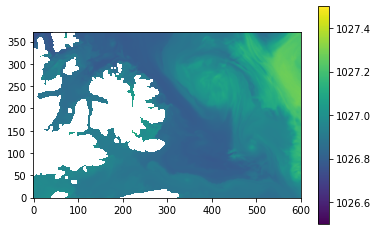

In [20]:
depth = 50

integrator_low = NetCDFInitialization.MLD_integrator(source_url, np.ma.array(depth*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
dens_low = np.sum(integrator_low * s_pot_densities, axis=0)

integrator_up = NetCDFInitialization.MLD_integrator(source_url, np.ma.array((depth-1/depth_show_resolution)*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
dens_up  = np.sum(integrator_up * s_pot_densities, axis=0)

densPlane = np.ma.array(dens_low - dens_up, mask=1-nc["mask_rho"][y0:y1,x0:x1])

plt.imshow(densPlane, vmin=1026.5, vmax=1027.5)
plt.colorbar()

In [21]:
mld = NetCDFInitialization.fill_coastal_data(NetCDFInitialization.MLD(source_url, np.ma.mean(densPlane), min_mld=15, max_mld=200, t=t, x0=x0, x1=x1, y0=y0, y1=y1))

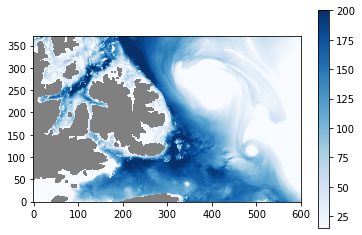

In [22]:
plt.imshow(mld, cmap="Blues")
plt.colorbar()

## GPU Ocean Simulations

In [15]:
t_start = t
t_stop =  t_start + 6

T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]

In [16]:
barotropic_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=timestep_indices, norkyst_data=False, land_value=5.0, download_data=False)

In [17]:
windage = 0.0

In [18]:
from gpuocean.SWEsimulators import CDKLM16

In [19]:
barotropic_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(barotropic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [20]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [21]:
# initx = [50000, 60000, 30000, 80000, 75000, 45000, 50000, 72500]
# inity = [40000, 30500,  5000, 30000, 15000, 50000,  7500, 45000]
initx = [47500, 60000, 72500, 80000, 72500, 50000, 30000]
inity = [42500, 30500, 37500, 27500, 15000,  7500,  5000]
# initx = [47500, 60000, 80000, 72500, 50000, 30000]
# inity = [42500, 30500, 27500, 15000,  7500,  5000]

num_drifters = len(initx)

In [22]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': barotropic_sim.nx, 'ny': barotropic_sim.ny,
                'domain_size_x': barotropic_sim.nx*barotropic_sim.dx,
                'domain_size_y': barotropic_sim.ny*barotropic_sim.dy,
                'land_mask': barotropic_sim.getLandMask()
                }

bt_trajectories = Observation.Observation(**observation_args)

In [21]:
bt_drifters = GPUDrifterCollection.GPUDrifterCollection(barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = barotropic_sim.boundary_conditions,
                                                    domain_size_x = bt_trajectories.domain_size_x,
                                                    domain_size_y = bt_trajectories.domain_size_y,
                                                    gpu_stream = barotropic_sim.gpu_stream,
                                                    wind = barotropic_data_args["wind"],
                                                    wind_drift_factor=windage
                                                    )

drifter_pos_init = np.array([initx, inity]).T
bt_drifters.setDrifterPositions(drifter_pos_init)

In [22]:
barotropic_sim.attachDrifters(bt_drifters)
bt_trajectories.add_observation_from_sim(barotropic_sim)

In [23]:
while barotropic_sim.t < T:
    barotropic_sim.step(300)
    bt_trajectories.add_observation_from_sim(barotropic_sim)

In [24]:
import matplotlib.lines as mlines

def plot_trajectory(trajectories0, trajectories1=None, zoom=[0, None, 0, None]):

    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=28)

    zoom_x0, zoom_x1, zoom_y0, zoom_y1 = zoom

    if zoom_x1 is None:
        dom_x1 = nx
    else:
        dom_x1 = zoom_x1
    if zoom_y1 is None:
        dom_y1 = ny
    else:
        dom_y1 = zoom_y1
    domain_extent = [zoom_x0*dx, dom_x1*dx, zoom_y0*dy, dom_y1*dy]

    bg_cmap = copy.deepcopy(plt.cm.Blues)
    bg_cmap.set_bad("grey", alpha = 1.0)

    ax.imshow(np.ma.array(nc["mask_rho"][y0:y1, x0:x1][zoom_y0:zoom_y1, zoom_x0:zoom_x1], mask=(1-nc["mask_rho"][y0:y1, x0:x1][zoom_y0:zoom_y1, zoom_x0:zoom_x1])), 
              interpolation="none", origin='lower', cmap=bg_cmap, extent=domain_extent)

    for d in range(len(initx)):
        path = trajectories0.get_drifter_path(d, 0, T, in_km = True)[0]
        start_pos = path[0,:]
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                0.1, color = 'black', fill=True, zorder=10)
        ax.add_patch(circ_start)

        ax.plot(path[:,0], path[:,1], color="C0", ls="-", zorder=5, alpha=1.0, lw=2.0)
        end_pos = path[-1,:]
        ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=50, linewidths=1, alpha=1.0, zorder=6)

        # -------------------
        if trajectories1 is not None:
            path = trajectories1.get_drifter_path(d, 0, T, in_km = True)[0]
            ax.plot(path[:,0], path[:,1], color="red", ls="-", zorder=5, alpha=1.0, lw=2.0)
            end_pos = path[-1,:]
            ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=50, linewidths=1, alpha=1.0, zorder=6)


        legend_handles = [ mlines.Line2D([], [], c="C0", lw=3, label="barotropic")]
        if trajectories1 is not None:
            legend_handles.append( mlines.Line2D([], [], c="red", lw=3, label="OpenDrift") )
        plt.legend(handles=legend_handles, handlelength=1,
        facecolor="white", framealpha=1,
        labelcolor="black", fontsize=18)

    plt.tight_layout()

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))


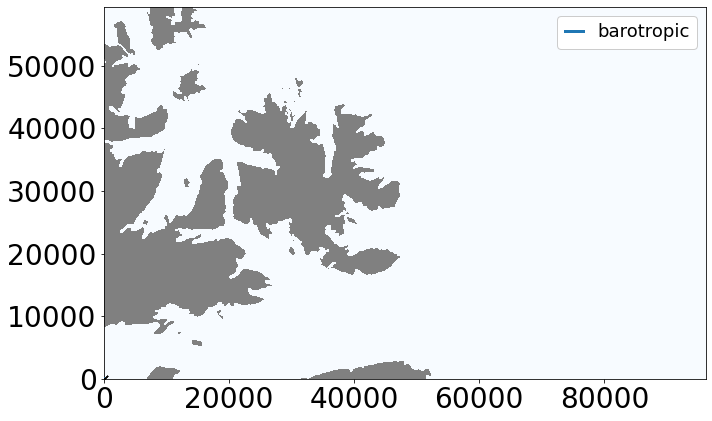

In [25]:
plot_trajectory(bt_trajectories)

## OpenDrift

In [26]:
from opendrift.readers import reader_netCDF_CF_generic, reader_ROMS_native
from opendrift.models.oceandrift import OceanDrift
from datetime import datetime, timedelta

import xarray as xr

In [27]:
reader = reader_ROMS_native.Reader(source_url)
reader.start_time

No proj string or projection could be derived, using 'fakeproj'. This assumes that the variables are structured and gridded approximately equidistantly on the surface (i.e. in meters). This must be guaranteed by the user. You can get rid of this warning by suppling a valid projection to the reader.


datetime.datetime(2020, 2, 1, 1, 0)

In [28]:
# Checking how to map (x,y) to/from (lon, lat)

#eta_rho: 801 xi_rho: 1161
lon0 = ds.lon_rho.isel(eta_rho=0, xi_rho=0).data, 
lat0 = ds.lat_rho.isel(eta_rho=0, xi_rho=0).data
print("lonlat(0, 0): ", (lon0, lat0))
print("\tgives (x, y): ", reader.lonlat2xy(lon0, lat0))

lonend = ds.lon_rho.isel(eta_rho=801-1, xi_rho=1161-1).data
latend = ds.lat_rho.isel(eta_rho=801-1, xi_rho=1161-1).data
print("lonlat(-1, -1): ", (lonend, latend))
print("\tgives (x, y): ", reader.lonlat2xy(lonend, latend))


lon0u = ds.lon_u.isel(eta_u=0, xi_u=0).data, 
lat0u = ds.lat_u.isel(eta_u=0, xi_u=0).data
print("lonlatu(0, 0): ", (lon0, lat0))
print("\tgives (x, y): ", reader.lonlat2xy(lon0, lat0))

lonlat(0, 0):  ((array(23.28394049),), array(69.12671479))
	gives (x, y):  (array([0.]), array([0.]))
lonlat(-1, -1):  (array(24.27178643), array(71.20140134))
	gives (x, y):  (array(1160.), array(800.))
lonlatu(0, 0):  ((array(23.28394049),), array(69.12671479))
	gives (x, y):  (array([0.]), array([0.]))


Based on the dimensions of eta_* and xi_*, it seems that eta_rho and xi_rho is from boundary to boundary. 

In [29]:
# Translate initx, inity to initlon, initlat
init_local_index_x = np.array(initx)/160
init_local_index_y = np.array(inity)/160

init_global_index_x = init_local_index_x + x0
init_global_index_y = init_local_index_y + y0

init_lon, init_lat = reader.xy2lonlat(init_global_index_x, init_global_index_y)
print("init_lon: ", init_lon)
print("init_lat: ", init_lat)

init_lon:  [25.76916237 26.27204517 26.3946213  26.7545123  26.84438575 26.52076251
 26.15672343]
init_lat:  [71.21974144 71.22016144 71.34822255 71.32851503 71.19530181 71.00002763
 70.85413722]


In [30]:
o = OceanDrift(loglevel=20)

#o.add_reader([reader_barents, reader_wind])
o.add_reader(reader)


15:57:57 INFO    opendrift.models.basemodel: OpenDriftSimulation initialised (version 1.8.5)


In [31]:
o.seed_elements(lat=init_lat, lon=init_lon, time=reader.start_time+ timedelta(hours=t), 
                wind_drift_factor=np.zeros_like(init_lat))


In [32]:
o.run(duration = timedelta(hours=6), time_step=600, time_step_output=600)


15:57:58 INFO    opendrift.models.basemodel: Fallback values will be used for the following variables which have no readers: 
15:57:58 INFO    opendrift.models.basemodel: 	upward_sea_water_velocity: 0.000000
15:57:58 INFO    opendrift.models.basemodel: 	sea_surface_wave_significant_height: 0.000000
15:57:58 INFO    opendrift.models.basemodel: 	sea_surface_wave_stokes_drift_x_velocity: 0.000000
15:57:58 INFO    opendrift.models.basemodel: 	sea_surface_wave_stokes_drift_y_velocity: 0.000000
15:57:58 INFO    opendrift.models.basemodel: 	sea_surface_wave_period_at_variance_spectral_density_maximum: 0.000000
15:57:58 INFO    opendrift.models.basemodel: 	sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment: 0.000000
15:57:58 INFO    opendrift.models.basemodel: 	surface_downward_x_stress: 0.000000
15:57:58 INFO    opendrift.models.basemodel: 	surface_downward_y_stress: 0.000000
15:57:58 INFO    opendrift.models.basemodel: 	turbulent_kinetic_energy: 0.000000
15:5

In [33]:
o_trajectories = Observation.Observation(domain_size_x=nx*dx, domain_size_y=ny*dy, nx=x1-x0, ny=y1-y0, land_mask=barotropic_sim.getLandMask())

In [34]:
ts = o.get_time_array()[1]
for i in range(len(ts)):
    ts[i] = ts[i].total_seconds()
ts = np.array(ts)

In [35]:
lon, lat = o.get_lonlats()
x,y = reader.lonlat2xy(lon,lat)

In [36]:
X = (x-x0)*160
Y = (y-y0)*160

In [37]:
o_trajectories = Observation.Observation(domain_size_x=dx*nx, domain_size_y=ny*dy,
                        nx=x1-x0, ny=y1-y0, land_mask=barotropic_sim.getLandMask())

In [38]:
o_trajectories.add_observations_from_arrays(ts, X, Y)

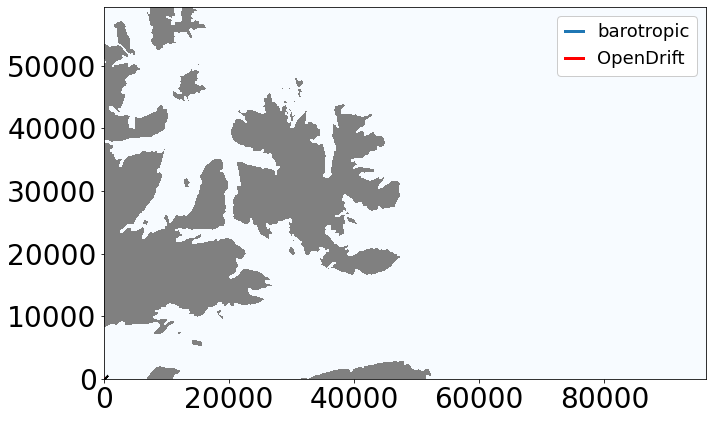

In [39]:
plot_trajectory(bt_trajectories, o_trajectories)

In [40]:
import datetime
[datetime.datetime.strftime(datetime.datetime.utcfromtimestamp(d), "%Y-%m-%d %H:00") for d in nc["ocean_time"][t_start:t_stop+1]]

['2042-02-01 10:00',
 '2042-02-01 11:00',
 '2042-02-01 12:00',
 '2042-02-01 13:00',
 '2042-02-01 14:00',
 '2042-02-01 15:00',
 '2042-02-01 16:00']

In [41]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import animation_utils

In [42]:
# animation_utils.ncAnimation(barotropic_sim.sim_writer.output_file_name, "gpuocean", comment="Barotropic", h_min=-1, h_max=1, uv_min=-100, uv_max=100, frequ=25)

In [43]:
# animation_utils.ncAnimation(source_url, "ROMS", t_range=[t_start, t_stop+1], ROMS_coord=[x0,x1,y0,y1], comment="NorFjord", h_min=-1, h_max=1, uv_min=-100, uv_max=100, frequ=25)

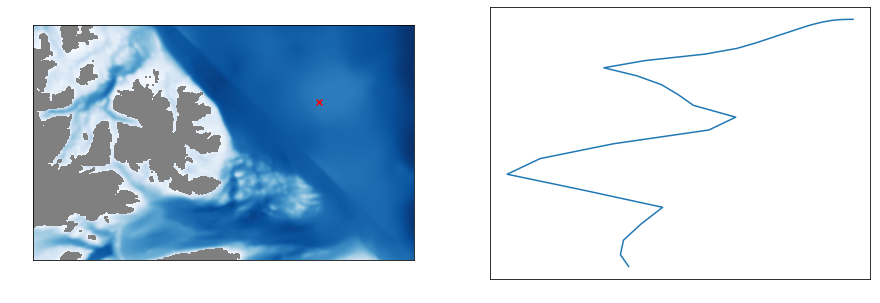

In [44]:
x, y = 450, 250

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].imshow(np.ma.array(nc["h"][y0:y1,x0:x1], mask=(1-nc["mask_rho"][y0:y1,x0:x1])), cmap="Blues")
axs[0].scatter(x,y, marker="x", color="red")

axs[1].plot( nc["u"][0,:,y0:y1,x0:x1][:,y,x], nc["Cs_r"]*(nc["h"][y0:y1,x0:x1][y,x]) ) 

Barotropic component

In [23]:
ubar = barotropic_data_args["hu0"]/nc["h"][y0:y1,x0:x1]
vbar = barotropic_data_args["hv0"]/nc["h"][y0:y1,x0:x1]

barotropicV = np.sqrt((ubar)**2 + (vbar)**2)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


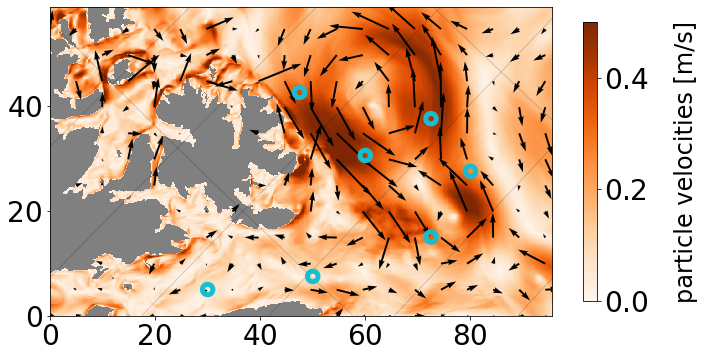

In [24]:
with plt.rc_context({'lines.color':'black', 
                    'text.color':'black', 
                    'axes.labelcolor':'black', 
                    'xtick.color':'black',
                    'ytick.color':'black'}):
    
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=28)

    domain_extent = [0, barotropic_sim.nx*barotropic_sim.dx/1000, 0, barotropic_sim.ny*barotropic_sim.dy/1000]

    cmap_cp = copy.copy(plt.cm.Oranges)
    cmap_cp.set_bad("grey", alpha = 1.0)

    im = ax.imshow(barotropicV,
                    interpolation="none", origin='lower', 
                    cmap=cmap_cp, 
                    vmin=0.0, vmax=0.5, 
                    extent=domain_extent)

    cb = plt.colorbar(im, ax=ax, shrink=0.4, pad=0.05) #, shrink=0.8)
    cb.ax.tick_params(labelsize=28)
    cb.formatter.set_powerlimits((-2, 2))
    cb.formatter.set_useMathText(True)
    cb.ax.yaxis.offsetText.set_fontsize(24)

    cb.set_label(label="particle velocities [m/s]", size=24, labelpad=25)

    try:
        lat = np.array(nc.variables["lat_rho"])
        lon = np.array(nc.variables["lon_rho"])

        spec_lat = lat[y0:y1, x0:x1]
        spec_lon = lon[y0:y1, x0:x1]

        cont_lon_case = ax.contour(spec_lon, levels = np.arange(20, 30, 0.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8)
        cont_lat_case = ax.contour(spec_lat, levels = np.arange(65, 75, 0.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8)

    except Exception as e:
        raise e

    frequency_x = 31
    frequency_y = 31
    x = np.arange(0, barotropicV.shape[1], frequency_x)*barotropic_sim.dx/1000
    y = np.arange(0, barotropicV.shape[0], frequency_y)*barotropic_sim.dy/1000
    qu = ubar[::frequency_y, ::frequency_x]
    qv = vbar[::frequency_y, ::frequency_x]

    ax.quiver(x, y, qu, qv)

    for d in range(len(initx)):
        circ_start = matplotlib.patches.Circle((initx[d]/1000, inity[d]/1000), 
                                                1.0, color = 'C9', linewidth=5,
                                                fill=False, zorder=10)
        ax.add_patch(circ_start)
        # ax.annotate(str(d),[initx[d]/1000-2, inity[d]/1000+2], fontsize=42 , color="C9")

    plt.tight_layout()

    folder = "barents_figs"
    os.makedirs(folder, exist_ok=True)
    plt.savefig(os.path.join(folder, "barents_barotropic_init.pdf"), bbox_inches="tight", dpi=800)

Baroclinic component

In [47]:
x0, x1, y0, y1 = 1100, dimX-350, 315, dimY-585
t = 9
t_start = t
t_stop =  t_start + 6

In [48]:
H = 25.0

In [49]:
integrator = NetCDFInitialization.MLD_integrator(source_url, np.ma.array(H*np.ones((y1-y0,x1-x0)), mask=1-nc["mask_rho"][y0:y1, x0:x1]), t=t_start, x0=x0, x1=x1, y0=y0, y1=y1)

In [50]:
u = np.ma.array(np.sum(integrator * nc["u"][t_start,:,y0:y1,x0:x1], axis=0), mask=1-nc["mask_rho"][y0:y1,x0:x1])/H
v = np.ma.array(np.sum(integrator * nc["v"][t_start,:,y0:y1,x0:x1], axis=0), mask=1-nc["mask_rho"][y0:y1,x0:x1])/H

baroclinicV = np.sqrt((u-ubar)**2 + (v-vbar)**2)

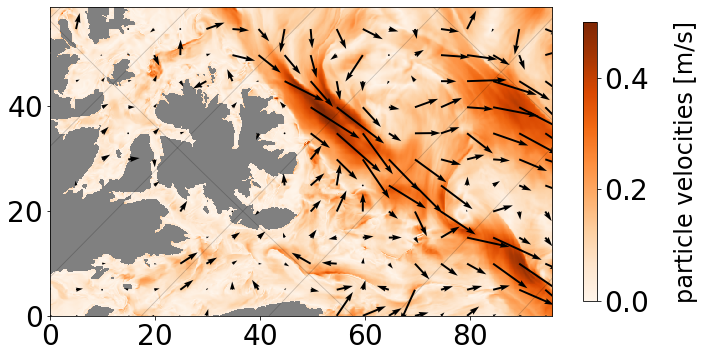

In [51]:
with plt.rc_context({'lines.color':'black', 
                    'text.color':'black', 
                    'axes.labelcolor':'black', 
                    'xtick.color':'black',
                    'ytick.color':'black'}):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=28)

    domain_extent = [0, barotropic_sim.nx*barotropic_sim.dx/1000, 0, barotropic_sim.ny*barotropic_sim.dy/1000]

    cmap_cp = copy.copy(plt.cm.Oranges)
    cmap_cp.set_bad("grey", alpha = 1.0)

    im = ax.imshow(baroclinicV,
                    interpolation="none", origin='lower', 
                    cmap=cmap_cp, 
                    vmin=0.0, vmax=0.5, 
                    extent=domain_extent)

    cb = plt.colorbar(im, ax=ax, shrink=0.4, pad=0.05) #, shrink=0.8)
    cb.ax.tick_params(labelsize=28)
    cb.formatter.set_powerlimits((-2, 2))
    cb.formatter.set_useMathText(True)
    cb.ax.yaxis.offsetText.set_fontsize(24)

    cb.set_label(label="particle velocities [m/s]", size=24, labelpad=25)

    try:
        lat = np.array(nc.variables["lat_rho"])
        lon = np.array(nc.variables["lon_rho"])

        spec_lat = lat[y0:y1, x0:x1]
        spec_lon = lon[y0:y1, x0:x1]

        cont_lon_case = ax.contour(spec_lon, levels = np.arange(20, 30, 0.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8)
        cont_lat_case = ax.contour(spec_lat, levels = np.arange(65, 75, 0.5), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8)

    except Exception as e:
        raise e

    frequency_x = 31
    frequency_y = 31
    x = np.arange(0, baroclinicV.shape[1], frequency_x)*barotropic_sim.dx/1000
    y = np.arange(0, baroclinicV.shape[0], frequency_y)*barotropic_sim.dy/1000
    qu = (u-ubar)[::frequency_y, ::frequency_x]
    qv = (v-vbar)[::frequency_y, ::frequency_x]

    ax.quiver(x, y, qu, qv)

    plt.tight_layout()

    folder = "barents_figs"
    os.makedirs(folder, exist_ok=True)
    plt.savefig(os.path.join(folder, "barents_baroclinic_init.pdf"), bbox_inches="tight", dpi=800)

In [52]:
np.abs(barotropicV).max(), np.abs(baroclinicV).max()

(1.0755040873251238, 0.5052712602157593)

In [53]:
np.mean(barotropicV), np.mean(baroclinicV)

(0.19655312949877332, 0.1273545090099952)

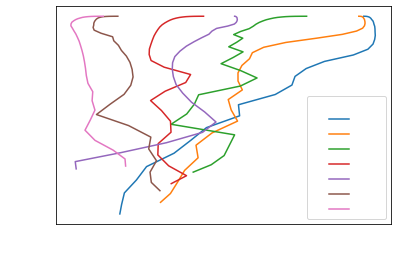

In [54]:
for d in range(num_drifters):
    x_idx = round(initx[d]/dx)
    y_idx = round(inity[d]/dy)

    lineH = nc["Cs_r"][:] * nc["h"][y0:y1,x0:x1][y_idx,x_idx]

    uline = nc["u"][t_start,:,y0:y1,x0:x1][:,y_idx, x_idx]
    vline = nc["v"][t_start,:,y0:y1,x0:x1][:,y_idx, x_idx]

    lineV = np.sqrt(uline**2+vline**2)

    plt.plot(lineV, lineH, label=str(d))

plt.xlabel("Velocity [m/s]")
plt.ylabel("Depth [m]")
plt.legend(title="init drifter pos")